In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import os
import pickle
import gpflow

import tensorflow as tf
from sklearn.metrics import r2_score

2025-08-26 16:54:48.028740: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-26 16:54:48.031469: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-26 16:54:48.038035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756248888.050792  121813 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756248888.054443  121813 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-26 16:54:48.067809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [10]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [11]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(5)

# Setup your client
client = Client(cluster)

2025-08-26 16:54:09,157 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x7fbfb4595420>>, <Task finished name='Task-19' coro=<SpecCluster._correct_state_internal() done, defined at /glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/distributed/deploy/spec.py:346> exception=RuntimeError('Command exited with non-zero exit code.\nExit code: 32\nCommand:\nqsub /glade/derecho/scratch/linnia/tmp/tmp_x4pf8vl.sh\nstdout:\n\nstderr:\nqsub: \nUnknown queue requested. Please correct or contact\ncislhelp@ucar.edu for assistance\n                        \n\n')>)
Traceback (most recent call last):
  File "/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/tornado/ioloop.py", line 750, in _run_callback
    ret = callback()
  File "/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/tornado/ioloop.py", line 774, in _discard_future_result
  

In [12]:
def build_X(biome,u_params,pft_params,biome_configs):

    u_lhc = params_lhc[u_params]
    u_wave1 = params_wave1.sel(param=u_params,pft=1)
    u_wave2 = params_wave2[u_params]
    uX = np.concatenate((u_lhc.values,u_wave1.values,u_wave2.values))
    
    X = pd.DataFrame(uX,columns=u_params)
    for pft in biome_configs[biome]['pfts']:
        param_names = [f"{param}_{pft}" for param in pft_params]
        
        p_lhc = params_lhc[pft_params]
        p_wave1 = params_wave1.sel(pft=pft,param=pft_params)
        p_wave2 = params_wave2[param_names]
    
        pX = np.concatenate((p_lhc.values,p_wave1.values,p_wave2.values))
        X = pd.concat([X, pd.DataFrame(pX, columns=param_names)], axis=1)
        
    return X

In [13]:
def train_val_save(X_train,X_test,y_train,y_test,kernel,outfile=None,savedir=None):

        model = gpflow.models.GPR(data=(X_train, np.float64(y_train)), kernel=kernel, mean_function=None)
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))

        # plot validation
        y_pred, y_pred_var = model.predict_y(X_test)
        sd = y_pred_var.numpy().flatten()**0.5

        coef_deter = r2_score(y_test,y_pred.numpy())

        if (savedir):
            print('saving')
            model.compiled_predict_f = tf.function(
                lambda X: model.predict_f(X, full_cov=False),
                input_signature=[tf.TensorSpec([None, np.shape(X_train)[1]], tf.float64)],
            )
            tf.saved_model.save(model, savedir)

        if (outfile):
            plt.figure()
            plt.errorbar(y_test, y_pred.numpy().flatten(), yerr=2*sd, fmt="o")
            plt.text(0.02, 0.98, f'R² = {np.round(coef_deter, 2)}',fontsize=10,transform=plt.gca().transAxes,va='top',ha='left')
            plt.text(0.02, 0.93, f'Emulator stdev ≈ {np.round(np.mean(sd), 2)}',fontsize=10,transform=plt.gca().transAxes,va='top',ha='left')
            plt.plot([0,np.max(y_test)],[0,np.max(y_test)],linestyle='--',c='k')
            plt.xlabel('CLM')
            plt.ylabel('Emulated')
            plt.xlim([np.min(y_test),np.max(y_test)])
            plt.ylim([np.min(y_test),np.max(y_test)])
            plt.tight_layout()
            plt.savefig(outfile)
    
        return coef_deter, np.mean(sd)



In [2]:
with open("biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

In [15]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
               'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

### load LHC

In [16]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')

infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku2_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)

# drop crashers
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
ix = np.where(ds_lhc.crashed==1)[0]
params_lhc = params.drop(ix-1)

lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()
gpp_lhc = (60*60*24)*lhc_pxb.GPP_biome_amean.sel(year=slice('2001','2015')).mean(dim='year').compute()
tvc_lhc = (1/1000)*lhc_pxb.TOTVEGC_biome_amean.sel(year=slice('2000','2019')).mean(dim='year').compute()

KeyboardInterrupt: 

### load Wave 1 

In [ ]:
######################################################
# load wave 1 data
filename = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave1/params/wave1_psets_021725.nc'
w1_params = xr.open_dataset(filename)

dir='/glade/work/linnia/CLM6-PPE/ctsm6_wave1/postp/'
ds = xr.open_dataset(dir+'ctsm6wave1_pxbmean_sudoku2_1985-2023.nc')

# drop crashers
ds_wave1 = ds.where(ds['crashed'] != 1, drop=True)

ix = np.where(ds.crashed==1)[0]
params_wave1 = w1_params['values'].drop_sel(ens=ix)
params_wave1 = params_wave1.transpose("ens", "param", "pft")
params_wave1 = params_wave1.sel(param=params_lhc.columns)

lai_wave1 = ds_wave1.TLAI_biome_amax.sel(year=slice(2001,2020)).mean(dim='year').compute()
gpp_wave1 = (60*60*24)*ds_wave1.GPP_biome_amean.sel(year=slice(2001,2015)).mean(dim='year').compute()
tvc_wave1 = (1/1000)*ds_wave1.TOTVEGC_biome_amean.sel(year=slice(2000,2019)).mean(dim='year').compute()

### Load wave2

In [ ]:
infile = '/glade/work/linnia/CLM6-PPE/ctsm6_wave2/postp/ctsm6wave2_pxbmean_sudoku2_1985-2023.nc'
ds = xr.open_dataset(infile)
wave2_pxb = ds.where(ds['crashed'] != 1, drop=True)
lai_wave2 = wave2_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()
gpp_wave2 = (60*60*24)*wave2_pxb.GPP_biome_amean.sel(year=slice('2001','2015')).mean(dim='year').compute()
tvc_wave2 = (1/1000)*wave2_pxb.TOTVEGC_biome_amean.sel(year=slice('2000','2019')).mean(dim='year').compute()

In [ ]:
df = pd.read_csv('/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/params/wave2_paramsets_041325.csv')
df = df.iloc[:, 1:]
ix = np.where(ds.crashed == 1)[0]
params_wave2 = df[~df.index.isin(ix)]

### Train LAI emulators

In [ ]:
np.random.seed(42) 
ntest = 250
X = build_X(1,u_params,pft_params,biome_configs)
ix_test = np.random.choice(np.arange(len(X)), size=ntest, replace=False)
ix_train = np.where(~np.isin(np.arange(len(X)), ix_test))[0]

In [ ]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
R2_score = np.empty(len(biome_ix)+1)*np.NaN
stdev = np.empty(len(biome_ix)+1)*np.NaN

10 Boreal forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Boreal forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Boreal forest/assets


IndexError: index 10 is out of bounds for axis 0 with size 2

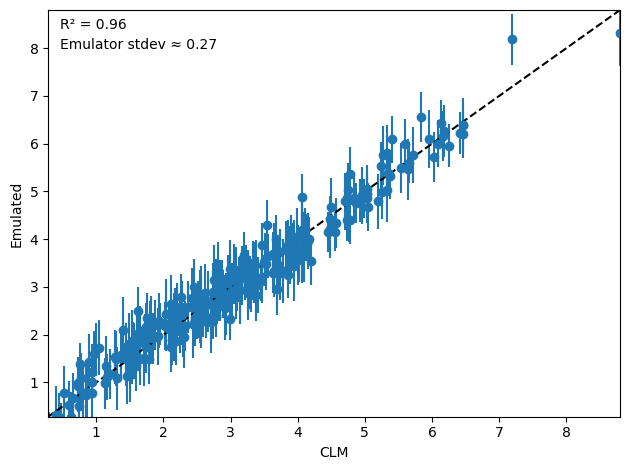

In [ ]:
# Train lai emulators
for b in biome_ix:
    biome_name = biome_configs[b]['name']
    print(b, biome_name)
    
    X = build_X(b,u_params,pft_params,biome_configs)
    y_lhc = lai_lhc.sel(biome=b).values[1:]
    y_wave1 = lai_wave1.sel(biome=b).values
    y_wave2 = lai_wave2.sel(biome=b).values
    Y = np.concatenate((y_lhc,y_wave1,y_wave2))
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome_name+'_emulator_validation_biomelaimax_compiled.png'
    savedir = str('./emulators_biomelai_compiled/'+biome_name)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    #best_kernel = kernel_dict[6]
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

### GPP

In [ ]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
R2_score = np.empty(14)*np.NaN
stdev = np.empty(14)*np.NaN

12 Arctic
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Arctic/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Arctic/assets


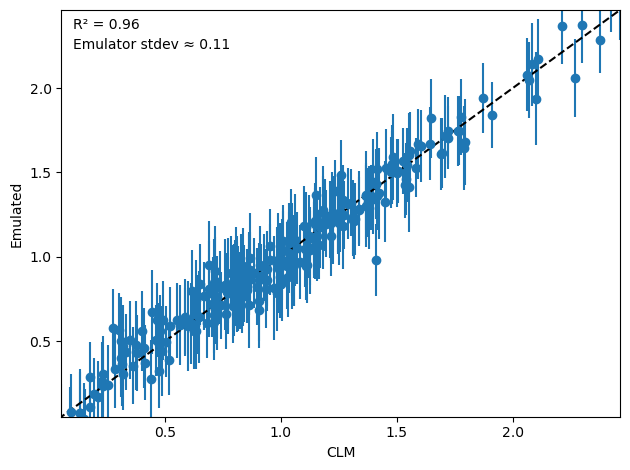

In [ ]:
# Train gpp emulators (gC/m2/day)
for b in biome_ix:
    biome_name = biome_configs[b]['name']
    print(b, biome_name)
    
    X = build_X(b,u_params,pft_params,biome_configs)
    y_lhc = gpp_lhc.sel(biome=b).values[1:]
    y_wave1 = gpp_wave1.sel(biome=b).values
    y_wave2 = gpp_wave2.sel(biome=b).values
    Y = np.concatenate((y_lhc,y_wave1,y_wave2))
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome_name+'_emulator_validation_biomegpp_compiled.png'
    savedir = str('./emulators_biomegpp_compiled/'+biome_name)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    #best_kernel = kernel_dict[6]
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

### Biomass

In [ ]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
R2_score = np.empty(14)*np.NaN
stdev = np.empty(14)*np.NaN

9 Siberian larch
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Siberian larch/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Siberian larch/assets


10 Boreal forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Boreal forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Boreal forest/assets


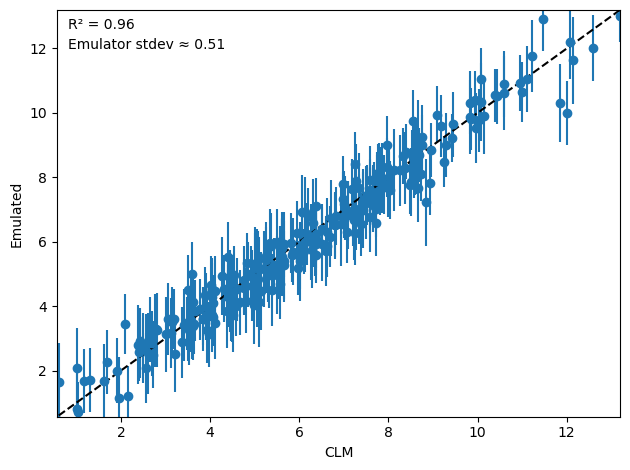

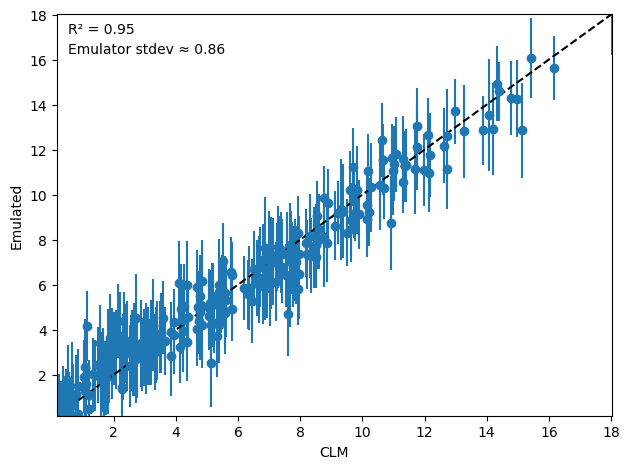

In [ ]:
# Train biomass emulators (kgC/m2)
for b in biome_ix:
    biome_name = biome_configs[b]['name']
    print(b, biome_name)
    
    X = build_X(b,u_params,pft_params,biome_configs)
    y_lhc = tvc_lhc.sel(biome=b).values[1:]
    y_wave1 = tvc_wave1.sel(biome=b).values
    y_wave2 = tvc_wave2.sel(biome=b).values
    Y = np.concatenate((y_lhc,y_wave1,y_wave2))
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome_name+'_emulator_validation_biomebiomass_compiled.png'
    savedir = str('./emulators_biomebiomass_compiled/'+biome_name)
    #best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    best_kernel = kernel_dict[6]
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

In [ ]:
def build_X(biome,u_params,pft_params,biome_configs):

    u_lhc = params_lhc[u_params]
    u_wave1 = params_wave1.sel(param=u_params,pft=1)
    u_wave2 = params_wave2[u_params]
    uX = np.concatenate((u_lhc.values,u_wave1.values,u_wave2.values))
    
    X = pd.DataFrame(uX,columns=u_params)
    for pft in biome_configs[biome]['pfts']:
        param_names = [f"{param}_{pft}" for param in pft_params]
        
        p_lhc = params_lhc[pft_params]
        p_wave1 = params_wave1.sel(pft=pft,param=pft_params)
        p_wave2 = params_wave2[param_names]
    
        pX = np.concatenate((p_lhc.values,p_wave1.values,p_wave2.values))
        X = pd.concat([X, pd.DataFrame(pX, columns=param_names)], axis=1)
        
    return X

10 Boreal forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled_v2/Boreal forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled_v2/Boreal forest/assets


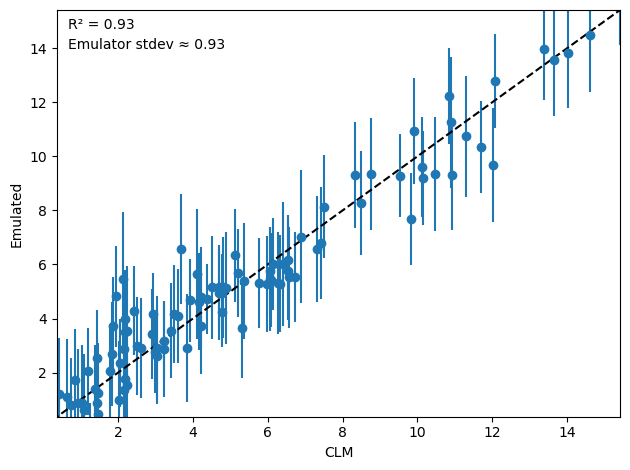

In [ ]:
# Train biomass emulators (kgC/m2)
np.random.seed(42) 
ntest = 100
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12]
for b in biome_ix:
    biome_name = biome_configs[b]['name']
    print(b, biome_name)

    # build X
    u_wave1 = params_wave1.sel(param=u_params,pft=1)
    u_wave2 = params_wave2[u_params]
    uX = np.concatenate((u_wave1.values,u_wave2.values))
    X = pd.DataFrame(uX,columns=u_params)
    for pft in biome_configs[b]['pfts']:
        param_names = [f"{param}_{pft}" for param in pft_params]
        p_wave1 = params_wave1.sel(pft=pft,param=pft_params)
        p_wave2 = params_wave2[param_names]
        pX = np.concatenate((p_wave1.values,p_wave2.values))
        X = pd.concat([X, pd.DataFrame(pX, columns=param_names)], axis=1)
    
    y_wave1 = tvc_wave1.sel(biome=b).values
    y_wave2 = tvc_wave2.sel(biome=b).values
    Y = np.concatenate((y_wave1,y_wave2))

    ix_test = np.random.choice(np.arange(len(X)), size=ntest, replace=False)
    ix_train = np.where(~np.isin(np.arange(len(X)), ix_test))[0]
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome_name+'_emulator_validation_biomebiomass_compiled_v2.png'
    savedir = str('./emulators_biomebiomass_compiled_v2/'+biome_name)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    #best_kernel = kernel_dict[6]
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

### Plot R2_score

In [6]:
R2_all = [[0.98400764, 0.97316751, 0.95563759, 0.97593961,
       0.95568081, 0.92420489, 0.96982609, 0.97480974, 0.96762595,
       0.97505006, 0.96039428, 0.95323824],
          [ 0.95482872, 0.95273323, 0.95871833, 0.94970905,
       0.95237934, 0.93912381, 0.9610817 , 0.95922815, 0.96754976,
       0.9610248 , 0.94861375, 0.95620227],
          [0.96,0.97,0.94,0.95,0.93,0.94,0.97,0.97,0.96,0.96,0.95,0.93]]

In [7]:
row_names = ['LAI', 'GPP', 'TOTVEGC']
biome_names = [b['name'] for b in biome_configs]
df = pd.DataFrame(R2_all,columns=biome_names[1:],index=row_names)

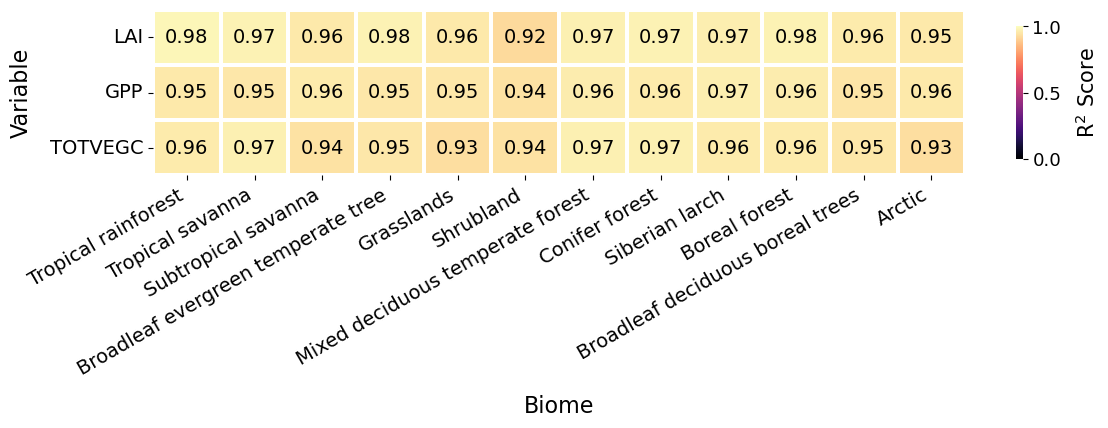

In [ ]:

import matplotlib as mpl

plt.figure(figsize=(12, 4.5))
ax = sns.heatmap(
    df, 
    annot=True, 
    cmap='magma', 
    vmin=0, 
    vmax=1, 
    fmt=".2f", 
    linewidths=1.5,
    linecolor='white',
    annot_kws={"size": 14,  "color": "black"},
    cbar_kws={"shrink": 0.8, "aspect": 20, "label": "R$^2$ Score"}
)

# Set axis label font sizes and weights
ax.set_xlabel("Biome", fontsize=16,  labelpad=12)
ax.set_ylabel("Variable", fontsize=16,  labelpad=12)

# Set tick label font sizes and weights
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14,  rotation=30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

# Set colorbar label font size and weight
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
cbar.set_label("R$^2$ Score", fontsize=15, labelpad=10)

# Remove spines for a cleaner look
for _, spine in ax.spines.items():
    spine.set_visible(False)

plt.tight_layout(pad=1.5)
plt.savefig('./figs/emulator_evaluation_heatmap.png', dpi=300, bbox_inches='tight', transparent=True)